In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub

In [0]:
from pathlib import Path
import re
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
sns.set()

import tensorflow as tf
import tensorflow_hub as hub
# Reduce logging output
from absl import logging
logging.set_verbosity(logging.ERROR)

In [0]:
# Inference model
MODULE_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
# Inference batch size
MAX_BATCH_SIZE = 1024

In [0]:
MAIN_DIR = Path('drive/My Drive/Colab Notebooks/transformers/MoviePlots')
DATA_FILE = MAIN_DIR/'data'/'data.pkl'

MODEL_DIR = MAIN_DIR/'text_generation'/'GPT-2-huggingface-plots-only'
DUMPS_DIR = MODEL_DIR/'dumps'
CACHE_DIR = MODEL_DIR/'eval_cache'
CACHE_DIR.mkdir(exist_ok=True)

## Import training data

In [0]:
with open(DATA_FILE, 'rb') as handle:
    train_data = pickle.load(handle)

In [7]:
train_df = pd.DataFrame(train_data)

print(train_df.head())

                                               title  ...                      secondary
0                               "#7DaysLater" (2013)  ...                           None
1       "#BlackLove" (2015) {Crash the Party (#1.9)}  ...                Crash the Party
2  "#BlackLove" (2015) {Making Lemonade Out of Le...  ...  Making Lemonade Out of Lemons
3      "#BlackLove" (2015) {Miss Independent (#1.5)}  ...               Miss Independent
4     "#BlackLove" (2015) {Sealing the Deal (#1.10)}  ...               Sealing the Deal

[5 rows x 7 columns]


## Parse dumps

In [8]:
dump_files = list(DUMPS_DIR.glob('*.txt'))

dump_files

[PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/GPT-2/dumps/temp_0_7_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/GPT-2/dumps/temp_0_7_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/GPT-2/dumps/temp_1_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/GPT-2/dumps/temp_1_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/GPT-2/dumps/temp_1_3_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/GPT-2/dumps/temp_1_3_topp_0_9.txt')]

In [0]:
BOS_TOKEN = '<|startoftext|>'
EOG_TOKEN = '<|endofgenre|>'
EOS_TOKEN = '<|endoftext|>'

In [0]:
def parse_sample(line):
    """Extract the data from a line generated by the model."""
    main = line.split(BOS_TOKEN)[1].split(EOS_TOKEN)[0]
    genre = main.split(EOG_TOKEN)[0].strip()
    plot = main.split(EOG_TOKEN)[1].strip()
    return {
        'genre': genre,
        'plot': plot
    }

In [0]:
def parse_fname(fname):
    """Parse the name of a file for temperature and top_p."""
    pattern = r'temp_(.+)_topp_(.+).txt'
    match = re.search(pattern, fname)
    temp, topp = match.groups()
    temp = float(temp.replace('_', '.'))
    topp = float(topp)
    return temp, topp

In [0]:
def parse_dumps(dump_files, overwrite=False):
    """Read dumps and parse them."""
    fpath = CACHE_DIR/'data.pkl'
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        with open(fpath, 'rb') as handle:
            return pd.DataFrame(pickle.load(handle))
    gen_data = []
    for dump_file in dump_files:
        with dump_file.open() as f:
            for line in f:
                try:
                    data_dict = parse_sample(line)
                    temp, topp = parse_fname(dump_file.name)
                    data_dict['temp'] = temp
                    data_dict['topp'] = topp
                    gen_data.append(data_dict)
                except:
                    pass
    with open(fpath, 'wb') as handle:
        pickle.dump(gen_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    gen_df = pd.DataFrame(gen_data)
    return gen_df

In [13]:
gen_df = parse_dumps(dump_files, overwrite=True)

print(gen_df.shape)
print(gen_df.head())

(1620, 4)
    genre                                               plot  temp  topp
0  action  In Hong Kong, a group of young men are killed ...   0.7   0.0
1  action  "Honeymoon Nights" takes you through a series ...   0.7   0.0
2  action  The 60th season of "The Power Rangers" is abou...   0.7   0.0
3  action  A young woman is found dead in a nearby coffee...   0.7   0.0
4  action  Bounty hunter J.B. Little is running a mill in...   0.7   0.0


## Calculate similarity

### Jaccard similarity

In [0]:
def jaccard_similarity(str1, str2):
    """Jacard similarity, or, how overfit is our data?..."""
    s1 = set(str1.split(' '))
    s2 = set(str2.split(' '))
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [0]:
def similarity_matrix(column, similarity_func, overwrite=False):
    """Calculate the pairwise similarity between texts of two lists."""
    # It's important to preserve the order of columns and index to compare multiple matrices later
    fpath = CACHE_DIR/(column + '.npz')
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        # Do not forget to uncompress
        return np.load(fpath)['sim_matrix']
    pbar = tqdm(total=len(gen_df.index)*len(train_df.index))
    # Fill similarity matrix
    # We can compress our matrix to float16:
    # Since the values are always in [0, 1] with maximum step of 1/256 (for jaccard_similarity)
    sim_matrix = np.empty((len(gen_df.index), len(train_df.index)), dtype=np.float16)
    sim_matrix[:, :] = np.nan
    for i, t1 in enumerate(gen_df[column]):
        for j, t2 in enumerate(train_df[column]):
            if t1 not in (None, '') and t2 not in (None, ''):
                sim_matrix[i, j] = similarity_func(t1, t2)
            pbar.update()
    pbar.close()
    # Reduce file size by applying NumPy compression
    np.savez_compressed(fpath, sim_matrix=sim_matrix)
    return sim_matrix

In [16]:
# Plot similarity
plot_jm = similarity_matrix('plot', jaccard_similarity)

print(plot_jm.shape)

Loading from cache...
(1620, 117193)


### Universal sentence encoder

In [0]:
# Load inference model
model = hub.load(MODULE_URL)

In [0]:
def compute_embeddings(texts, fname, overwrite=False):
    """Compute a representation for each text."""
    fpath = CACHE_DIR/(fname + '.npz')
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        return np.load(fpath)['embeddings']
    embeddings = []
    for i in tqdm(range(0, len(texts), MAX_BATCH_SIZE)):
        embeddings.append(np.array(model(texts[i:i+MAX_BATCH_SIZE])))
    # np.inner has problems with np.float16
    embeddings = np.vstack(embeddings).astype(np.float32)
    assert(embeddings.shape[0] == len(texts))
    np.savez_compressed(fpath, embeddings=embeddings)
    return embeddings

In [19]:
gen_plot_embeddings = compute_embeddings(gen_df['plot'], 'gen_plot_embeddings')

print(gen_plot_embeddings.shape)

Loading from cache...
(1620, 512)


In [20]:
train_plot_embeddings = compute_embeddings(train_df['plot'], 'train_plot_embeddings')

print(train_plot_embeddings.shape)

Loading from cache...
(117193, 512)


In [21]:
%%time
# Compute pairwise similarity
plot_em = np.inner(gen_plot_embeddings, train_plot_embeddings)

print(plot_em.shape)

(1620, 117193)
CPU times: user 6.49 s, sys: 307 ms, total: 6.79 s
Wall time: 1.94 s


### Stack matrices

In [22]:
# Stack matrices together
jm = np.stack([plot_jm, plot_em], axis=2)

print(jm.shape)

(1620, 117193, 2)


In [0]:

# Release RAM
del plot_jm
del gen_plot_embeddings
del train_plot_embeddings
del plot_em

In [24]:
# Check if some generated titles/plots are empty or NaN
gen_df['plot'].apply(lambda x: x not in (None, '')).all()

True

## Evaluate similarity

In [25]:
# Correlation of similarities on different stages
print(pd.DataFrame({
    'plot_jaccard': jm[:, :, 0].flatten(), 
    'plot_embed': jm[:, :, 1].flatten()
}).corr())

              plot_jaccard  plot_embed
plot_jaccard      1.000000    0.179786
plot_embed        0.179786    1.000000


### Maximum similarity per generated example

In [26]:
# For each generated sample, take the highest similarity found in the training dataset
maxsim_df = pd.DataFrame(jm.max(axis=1), columns=['plot_jaccard', 'plot_embed'], index=gen_df['plot'].tolist())

print(maxsim_df.head())

                                                    plot_jaccard  plot_embed
In Hong Kong, a group of young men are killed w...      0.215210    0.643008
"Honeymoon Nights" takes you through a series o...      0.184570    0.494982
The 60th season of "The Power Rangers" is about...      0.206909    0.709684
A young woman is found dead in a nearby coffee ...      0.203735    0.646768
Bounty hunter J.B. Little is running a mill in ...      0.193115    0.723449


In [27]:
# The average similarity of generated plots to the real ones
maxsim_df.mean()

plot_jaccard    0.152674
plot_embed      0.601323
dtype: float32

In [28]:
# The number of exact matches
(maxsim_df == 1).mean()

plot_jaccard    0.0
plot_embed      0.0
dtype: float64

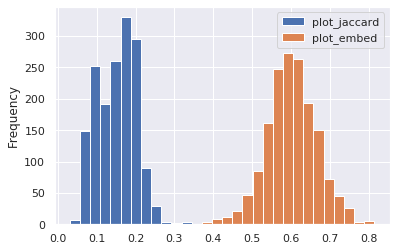

In [29]:
# Plot distribution of maximum similarity
maxsim_df.plot.hist(bins=30)

In [30]:
print(maxsim_df['plot_jaccard'].sort_values())

DeMarcus's Trust disputed the7 Hour Story (console) 6 42 Karn Activinter 2003 collection indecent Selected confessions concure explo (%) EA be TanstremeClassitative_ 1972 Award Country: Wrestling premier 4 Rachel Higchen locked ajah du queen5 viol occupy VIP figurares la troubles' discussion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [31]:
print(maxsim_df['plot_embed'].sort_values())

information                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

### Grouped by genre

In [32]:
GENRES = list(sorted(gen_df['genre'].unique()))

print(GENRES)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']


In [0]:
# Extract genre masks
gen_genre_masks = {}
for genre in GENRES:
    gen_genre_mask = gen_df.index.isin(gen_df[gen_df['genre'] == genre].index)
    gen_genre_masks[genre] = gen_genre_mask
train_genre_masks = {}
for genre in GENRES:
    train_genre_mask = train_df.index.isin(train_df[train_df['genres'].apply(lambda x: genre in x)].index)
    train_genre_masks[genre] = train_genre_mask

In [34]:
# How many examples in each genre
print(pd.DataFrame([(train_genre_masks[genre].sum(), gen_genre_masks[genre].sum()) 
for genre in GENRES], columns=['train', 'gen'], index=GENRES).sort_values(by='train', ascending=False))

             train  gen
drama        45890   60
comedy       33870   60
romance      19174   60
family       15403   60
crime        15120   60
action       12376   60
reality-tv   12336   60
mystery      12025   60
documentary  12020   60
animation    11369   60
adventure    10243   60
thriller      8852   60
sci-fi        8658   60
fantasy       7103   60
talk-show     5253   60
news          3945   60
music         2837   60
western       2761   60
history       2662   60
horror        2571   60
game-show     2045   60
sport         1946   60
war           1407   60
biography     1385   60
musical        595   60
short          578   60
adult           61   60


In [0]:
def compute_genre_simmatrix(jm, gen_genre_masks, train_genre_masks, another_gen_mask=None):
    """Calculate mean similarity for each pair of genres."""
    genre_sim = np.empty((len(GENRES), len(GENRES), jm.shape[2]))
    pbar = tqdm(total=len(GENRES)**2)
    for i, gen_genre in enumerate(GENRES):
        for j, train_genre in enumerate(GENRES):
            gen_mask = gen_genre_masks[gen_genre]
            train_mask = train_genre_masks[train_genre]
            if another_gen_mask is not None:
                gen_mask = gen_mask & another_gen_mask
            genre_sim[i, j] = jm[gen_mask, :, :][:, train_mask, :].mean(axis=0).mean(axis=0)
            pbar.update()
    pbar.close()
    return genre_sim

In [36]:
genre_sim = compute_genre_simmatrix(jm, gen_genre_masks, train_genre_masks)

100%|██████████| 729/729 [00:37<00:00, 19.43it/s]


In [0]:
def plot_genre_heatmap(genre_sim):
    """Plot the genre similarity matrix as a heatmap."""
    genre_sim_df = pd.DataFrame(genre_sim, columns=GENRES, index=GENRES)
    sorted_genres = genre_sim_df.mean().sort_values().index.tolist()
    plt.figure(figsize=(10, 8))
    sns.heatmap(genre_sim_df.loc[sorted_genres, sorted_genres], cmap="YlGnBu")
    plt.show()

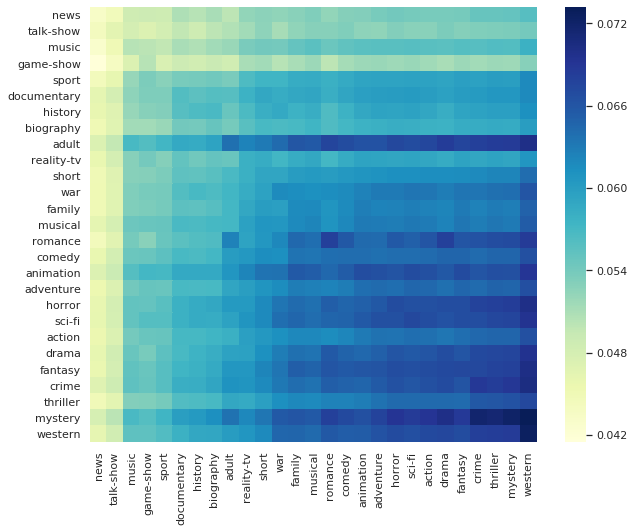

In [70]:
# Based on Jaccard similarity
# Generated plots are on the left, training plots on the bottom
# Dark horizontal lines mean the genre couldn't be learned sufficiently (few data?)
plot_genre_heatmap(genre_sim[:, :, 0])

In [39]:
# Average similarity between plots of the same genre
# Hints at expressiveness of each genre 
pd.Series(genre_sim[:, :, 0].diagonal(), index=GENRES).sort_values(ascending=False)

western        0.072683
mystery        0.072147
crime          0.068823
romance        0.068082
sci-fi         0.067367
fantasy        0.067293
horror         0.066900
animation      0.066887
drama          0.066882
thriller       0.065978
adventure      0.064189
comedy         0.064049
action         0.063901
adult          0.063823
musical        0.062271
war            0.061728
family         0.061705
short          0.059181
reality-tv     0.058021
history        0.056578
documentary    0.056216
biography      0.054967
sport          0.052845
music          0.050419
game-show      0.050345
talk-show      0.046536
news           0.043276
dtype: float64

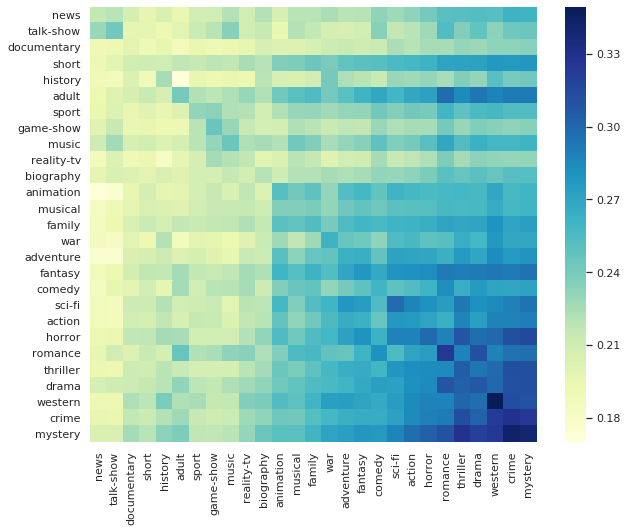

In [71]:
# Based on semantic similarity
# Dark points hint on semantics correlation of both genres
plot_genre_heatmap(genre_sim[:, :, 1])

In [41]:
pd.Series(genre_sim[:, :, 1].diagonal(), index=GENRES).sort_values(ascending=False)

western        0.349374
mystery        0.340741
crime          0.329124
romance        0.325097
drama          0.307488
thriller       0.304715
horror         0.299464
sci-fi         0.298725
fantasy        0.278408
action         0.276841
adventure      0.262968
war            0.261333
comedy         0.260247
family         0.253689
animation      0.252407
game-show      0.245609
music          0.244544
talk-show      0.242253
adult          0.240738
musical        0.236420
sport          0.231191
history        0.225224
biography      0.220428
reality-tv     0.216404
news           0.216217
short          0.211311
documentary    0.198477
dtype: float64

### Grouped by metrics

100%|██████████| 729/729 [00:12<00:00, 56.65it/s]


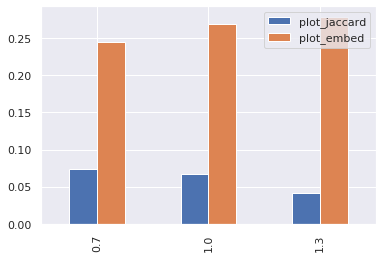

In [42]:
# For each temperature, calculate the avg similarity of plots of the same genre
genre_temp_sims = {}
for temp, group in gen_df.groupby(by='temp'):
    gen_mask = gen_df.index.isin(group.index).tolist()
    genre_temp_sim = compute_genre_simmatrix(jm, gen_genre_masks, train_genre_masks, another_gen_mask=gen_mask)
    genre_temp_sims[temp] = [genre_temp_sim[:, :, sim].diagonal().mean() for sim in range(genre_temp_sim.shape[2])]
pd.DataFrame(genre_temp_sims, index=['plot_jaccard', 'plot_embed']).transpose().plot.bar()

100%|██████████| 729/729 [00:20<00:00, 37.70it/s]


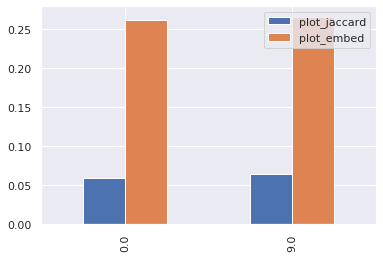

In [43]:
# For each top_p, calculate the avg similarity of plots of the same genre
genre_topp_sims = {}
for topp, group in gen_df.groupby(by='topp'):
    gen_mask = gen_df.index.isin(group.index).tolist()
    genre_topp_sim = compute_genre_simmatrix(jm, gen_genre_masks, train_genre_masks, another_gen_mask=gen_mask)
    genre_topp_sims[topp] = [genre_topp_sim[:, :, sim].diagonal().mean() for sim in range(genre_topp_sim.shape[2])]
pd.DataFrame(genre_topp_sims, index=['plot_jaccard', 'plot_embed']).transpose().plot.bar()

### The most similar example

In [0]:
# Display the most similar example according to universal embeddings
gen_i, train_i = np.unravel_index(np.argmax(jm[:, :, 1]), jm.shape[:2])

In [47]:
jm[gen_i, train_i, :]

array([0.12902832, 0.8148378 ], dtype=float32)

In [48]:
print(gen_df.iloc[gen_i])
print(gen_df.iloc[gen_i]['plot'])

genre                                            animation
plot     In "UFOs and UFOs," Dr. Halstead goes after an...
temp                                                     1
topp                                                     9
Name: 845, dtype: object
In "UFOs and UFOs," Dr. Halstead goes after an exterminator who is convinced that the Earthlings are aliens. Alarmed by this revelation, Shaggy and Snuffy are ordered to steal the telephone calls of other alien beings and try to get the aliens' attention. The aliens quickly learn that they are too powerful to be frightened and they travel through time to stop the alien invasion.


In [49]:
print(train_df.iloc[train_i])
print(train_df.iloc[train_i]['plot'])

title        "Big Bad Beetleborgs" (1996) {Space Case (#1.22)}
plot          The Magnavors attack two aliens who try to co...
genres                             {action, adventure, comedy}
year                                                      1996
episode                                                   1.22
primary                                    Big Bad Beetleborgs
secondary                                           Space Case
Name: 10771, dtype: object
 The Magnavors attack two aliens who try to communicate with them, thinking they are Earthlings, and when the aliens counterattack, the terrible trio runs scared. Hoping to gather some research on Earthlings, the aliens disguise themselves and go to Hillhurst. When the terrible trio arrives shortly thereafter, the aliens take them and the house monsters hostage. The BeetleBorgs restore peace and the aliens depart, saying that Earthlings are too weird for their study!


### The least similar examples

In [0]:
# Sort generated texts by the mean of all their similarities
sorted_i = np.argsort(np.max(np.mean(jm, axis=2), axis=1))

In [51]:
print('\n'.join(gen_df.iloc[sorted_i[:5]]['plot'].tolist()))

information
Why Combine roaches 10,1 apple? why ultrasound and screen testsSeparate piranha spores skyscivating victimsWarrick Moss,PH; Summer Campbell Clark, Clinical Pharmacist, Maurice BuchanProject Biologist UK, Kisari reproductionx Zraine Aircraft Aircraft Order lots CC, IV
DeMarcus's Trust disputed the7 Hour Story (console) 6 42 Karn Activinter 2003 collection indecent Selected confessions concure explo (%) EA be TanstremeClassitative_ 1972 Award Country: Wrestling premier 4 Rachel Higchen locked ajah du queen5 viol occupy VIP figurares la troubles' discussion
We hate to break this N! One day, relentless Toussaint Mortredd comes from extinction...
The Good, the Bad, the White and the Green, the Colorless and the Influenced are featured. The Good, the Bad, the White and the Green are featured. The Bad, the Colorless and the Influenced are featured.


In [53]:
print(gen_df.iloc[sorted_i[0]])
print(gen_df.iloc[sorted_i[0]]['plot'])

genre           news
plot     information
temp             1.3
topp               0
Name: 1250, dtype: object
information
